In [1]:
# import project Libraries 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the data and create pandas DataFrame. 
df = pd.read_csv('./My_data/Food_enforcement_data.csv',encoding= 'unicode_escape')

In [3]:
# Exploring the summary of our DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20677 entries, 0 to 20676
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   FEI_Number              20677 non-null  object
 1   Product ID              20677 non-null  int64 
 2   Recalling_Firm          20677 non-null  object
 3   Product_Type            20677 non-null  object
 4   Status                  20677 non-null  object
 5   Recalling_Firm_City     20677 non-null  object
 6   Recalling_Firm_State    20677 non-null  object
 7   Recalling_Firm_Country  20677 non-null  object
 8   Classification_Date     20677 non-null  object
 9   Recall_Reason           20677 non-null  object
 10  Product_Description     20677 non-null  object
 11  Classification          20677 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.9+ MB


In [4]:
# get columns names( this works as week refrence once i start dropping columns not needed)
df.columns

Index(['FEI_Number', 'Product ID', 'Recalling_Firm', 'Product_Type', 'Status',
       'Recalling_Firm_City', 'Recalling_Firm_State', 'Recalling_Firm_Country',
       'Classification_Date', 'Recall_Reason', 'Product_Description',
       'Classification'],
      dtype='object')

In [5]:
# To identify any missing data (null value) and deal with with it. 
df.isnull().sum()

FEI_Number                0
Product ID                0
Recalling_Firm            0
Product_Type              0
Status                    0
Recalling_Firm_City       0
Recalling_Firm_State      0
Recalling_Firm_Country    0
Classification_Date       0
Recall_Reason             0
Product_Description       0
Classification            0
dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
# LabelEncoder is used when Encoding Categorical features to numerical. 
label_encode = LabelEncoder()

In [8]:
# Label encoding is performed on the target class "Classification" because its ordinal in nature
df["Classification"] = label_encode.fit_transform(df['Classification'].astype('str'))

In [9]:
# Source: https://maxhalford.github.io/blog/target-encoding-done-the-right-way/
def calc_smooth_mean(df1, df2, cat_name, target, weight):
    # Compute the global mean
    mean = df[target].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(cat_name)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + weight * mean) / (counts + weight)

    # Replace each value by the according smoothed mean
    if df2 is None:
        return df1[cat_name].map(smooth)
    else:
        return df1[cat_name].map(smooth),df2[cat_name].map(smooth.to_dict())


WEIGHT = 5
df['Recall_Reason'] = calc_smooth_mean(df1=df, df2=None, cat_name='Recall_Reason', target='Classification', weight=WEIGHT)
df['Product_Description'] = calc_smooth_mean(df1=df, df2=None, cat_name='Product_Description', target='Classification', weight=WEIGHT)

In [10]:
import category_encoders as ce

In [11]:
# here we are encoding "Classification column" which has ordinal data (ClassI, Class II, Class III)
# Using LabelEncoder technique. 
encode = ce.OneHotEncoder(cols='Classification',handle_unknown='return_nan',return_df=True,use_cat_names=True)
data_encoded = encode.fit_transform(df)

In [12]:
# Here we are Encoding 'Recalling_Firm_City' Column using binary Encoding technique
encode_0 = ce.BinaryEncoder(cols=['Recalling_Firm_City'],return_df=True)
data_encoded = encode_0.fit_transform(data_encoded)

In [13]:
# encoding column "status" using One-Hot-Encode method
enoder_1 = ce.OneHotEncoder(cols='Status',handle_unknown='return_nan',return_df=True,use_cat_names=True)

In [14]:
# Trnsforming the encoded data. 
data_encoded = enoder_1.fit_transform(data_encoded)

In [15]:
# Here we are Encoding 'Recalling_Firm_Country' Column using binary Encoding technique
encoder_2 = ce.BinaryEncoder(cols=['Recalling_Firm_Country'],return_df=True)

In [16]:
# Trnsforming the encoded data. 
data_encoded = encoder_2.fit_transform(data_encoded)

In [17]:
# drop unwanted columns 
data_encoded = data_encoded.drop('Recalling_Firm_State',axis=1)

In [18]:
# Dropping all Columns deemed unNecessary for the model performance 
data_encoded = data_encoded.drop('Product_Type',axis=1)
data_encoded = data_encoded.drop('Recalling_Firm',axis=1)
data_encoded = data_encoded.drop('Product ID',axis=1)
data_encoded = data_encoded.drop('FEI_Number',axis=1)
data_encoded = data_encoded.drop('Classification_Date',axis=1)

In [19]:

X = data_encoded.iloc[:,:23].values
y = data_encoded.iloc[:,23:].values

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
#Training test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = MinMaxScaler()

In [24]:
# Feature scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# Import model frameworks and libraries 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
# the model takes in 15507 records with 23 input features 
model = Sequential()
model.add(Dense(24, input_dim=23, activation='relu', # rectified linear activation function is the function of choice 
                kernel_initializer='random_normal')) #nitializer that generates tensors with a normal distribution.
model.add(Dense(12,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(6,activation='relu',kernel_initializer='random_normal'))
# softmax is the activation of choice for multiclass Classification problems
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)

In [27]:
# model fiting 
# when trining the model, i have introduced Keras callbacks functions i.e early stopping to prevent overfitting 
model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Train on 15507 samples, validate on 5170 samples
Epoch 1/1000
15507/15507 - 2s - loss: 0.7732 - accuracy: 0.6579 - val_loss: 0.3230 - val_accuracy: 0.9313
Epoch 2/1000
15507/15507 - 1s - loss: 0.2305 - accuracy: 0.9320 - val_loss: 0.1593 - val_accuracy: 0.9381
Epoch 3/1000
15507/15507 - 1s - loss: 0.1102 - accuracy: 0.9610 - val_loss: 0.0724 - val_accuracy: 0.9733
Epoch 4/1000
15507/15507 - 1s - loss: 0.0533 - accuracy: 0.9899 - val_loss: 0.0393 - val_accuracy: 0.9973
Epoch 5/1000
15507/15507 - 1s - loss: 0.0325 - accuracy: 0.9992 - val_loss: 0.0258 - val_accuracy: 0.9990
Epoch 6/1000
15507/15507 - 1s - loss: 0.0226 - accuracy: 0.9993 - val_loss: 0.0180 - val_accuracy: 0.9996
Epoch 7/1000
15507/15507 - 1s - loss: 0.0163 - accuracy: 0.9994 - val_loss: 0.0130 - val_accuracy: 0.9996
Epoch 8/1000
15507/15507 - 1s - loss: 0.0120 - accuracy: 0.9996 - val_loss: 0.0096 - val_accuracy: 0.9998
Epoch 9/1000
15507/15507 - 1s - loss: 0.0091 - accuracy: 0.9997 - val_loss: 0.0074 - val_accuracy: 0.99

In [28]:
#create a data frame of model metrics i.e losses and accuracy 
df_loss = pd.DataFrame(model.history.history)
df_loss

,loss,accuracy,val_loss,val_accuracy
0,0.773185,0.657896,0.323000,0.931335
1,0.230542,0.931966,0.159310,0.938104
2,0.110225,0.960985,0.072380,0.973308
3,0.053283,0.989940,0.039281,0.997292
4,0.032454,0.999226,0.025803,0.999033
5,0.022577,0.999291,0.017980,0.999613
6,0.016344,0.999355,0.013012,0.999613
7,0.012012,0.999613,0.009615,0.999807
8,0.009081,0.999678,0.007397,0.999807
9,0.007208,0.999678,0.005807,0.999807


<AxesSubplot:>

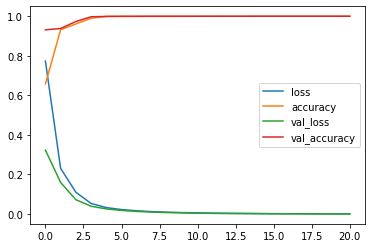

In [29]:
# ploting loss against validation loss and accuracy vas validation accuracy
df_loss.plot()

In [30]:
# predict unseen test data
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

In [31]:
from sklearn import metrics

y_compare = np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 1.0


In [32]:
# define a confusion matrix
def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[2168    0    0]
 [   0 2715    0]
 [   0    0  287]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


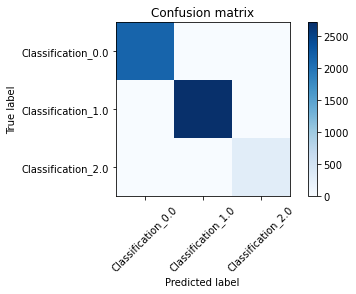

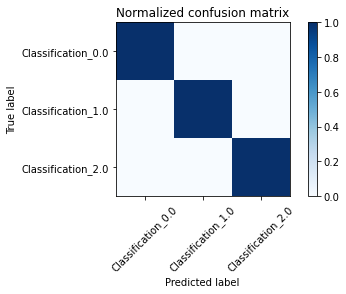

In [33]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
My_products = pd.DataFrame(data_encoded.iloc[:,23:])
products = My_products.columns
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, products)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, 
        title='Normalized confusion matrix')

plt.show()

In [34]:
pred[:30]

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       2, 1, 0, 1, 0, 0, 0, 0])

In [35]:
# Evaluate the model performance 
model.evaluate(X_test,y_test,verbose=0)

[0.0013125953449909548, 1.0]

In [36]:
epochs = len(df_loss)

In [37]:
# here we will scale the whole dataset without spliting 
scaled_X = scaler.fit_transform(X)

In [38]:
# Second model but this time with all the 20677 dataset record (no splitting)
model = Sequential()
model.add(Dense(X.shape[1],input_dim=23, activation='relu',
                kernel_initializer='random_normal'))
model.add(Dense(12,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(6,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)

In [39]:
model.fit(scaled_X,y,validation_data=(X_test,y_test),callbacks=[monitor],verbose=2,epochs=500)

Train on 20677 samples, validate on 5170 samples
Epoch 1/500
20677/20677 - 2s - loss: 0.8724 - accuracy: 0.5154 - val_loss: 0.8197 - val_accuracy: 0.5251
Epoch 2/500
20677/20677 - 1s - loss: 0.3644 - accuracy: 0.8624 - val_loss: 0.1008 - val_accuracy: 0.9375
Epoch 3/500
20677/20677 - 1s - loss: 0.0682 - accuracy: 0.9700 - val_loss: 0.0462 - val_accuracy: 0.9990
Epoch 4/500
20677/20677 - 1s - loss: 0.0329 - accuracy: 0.9989 - val_loss: 0.0146 - val_accuracy: 0.9998
Epoch 5/500
20677/20677 - 1s - loss: 0.0059 - accuracy: 0.9998 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 6/500
20677/20677 - 1s - loss: 0.0016 - accuracy: 0.9999 - val_loss: 6.3667e-04 - val_accuracy: 1.0000
Epoch 7/500
20677/20677 - 1s - loss: 9.8296e-04 - accuracy: 1.0000 - val_loss: 3.3676e-04 - val_accuracy: 1.0000
Epoch 8/500
20677/20677 - 1s - loss: 7.0066e-04 - accuracy: 0.9999 - val_loss: 1.8019e-04 - val_accuracy: 1.0000
Epoch 9/500
20677/20677 - 1s - loss: 5.9281e-04 - accuracy: 1.0000 - val_loss: 1.3180e-04 -

In [40]:
from tensorflow.keras.models import load_model

In [41]:
# Saving the model
model.save('Food_racall_draft.h5')

In [42]:
predictions = model.predict(X)

In [43]:
predictions = np.argmax(predictions,axis=1)

In [44]:
import joblib

In [45]:
# Save the scaler
joblib.dump(scaler, 'food_recall_scaler.pki')

['food_recall_scaler.pki']

In [46]:
# this list will hold all products classified as class I or II 
Class_I_and_II_products = []

In [47]:
# In this prediction model the predicted items are at the same index as they were in the original dataframe
# for example if product id 184301 was at position 44 in the original dataframe i.e df then it will be at the same
# index position 44 in the predictions

for index in range(df.shape[0]):
    if predictions[index] ==0 | predictions[index] ==1:
        Class_I_and_II_products.append(df.loc[index,['Product ID']][0]) # get the preduct id if it's class I or II

In [48]:
# A list of product classified as class I and II with potentital to be withdrawn. 
Class_I_and_II_products[:20]

[184301,
 184193,
 184392,
 184262,
 184323,
 183709,
 184228,
 184272,
 184037,
 184181,
 184182,
 184183,
 184184,
 184185,
 184186,
 184187,
 184188,
 184189,
 184191,
 184192]

In [49]:
# Determine which countries whose recalled products are classified as Class I or II 
violating_Countries = [df.loc[index,['Recalling_Firm_Country']][0] for index in range(df.shape[0]) if predictions[index] ==0 |predictions[index] ==1]

In [50]:
def High_Violating_countries(Country_list):
    
    country_dictionary = {} 
    for country in Country_list:
        if country not in country_dictionary:
            country_dictionary[country] = violating_Countries.count(country)
    sorted(country_dictionary.items(), key=lambda x: x[1], reverse=True)
    return country_dictionary
    

In [51]:
high_riask_countries = High_Violating_countries(violating_Countries)

In [52]:
# return countries that appears at least five times in the violation list.
for key, value in high_riask_countries.items():
    if value >= 5:
        print("{:>10} has {:>5} food products in Violation ".format(key, value))

United States has  8508 food products in Violation 
    Canada has    53 food products in Violation 
    France has     5 food products in Violation 
     Chile has     6 food products in Violation 
    Mexico has     6 food products in Violation 
